In [2]:
%load_ext autoreload
%autoreload 2


import torch
from torch import nn
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
from torchvision.models import ViT_L_16_Weights, vit_l_16
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm.auto import tqdm

from drecg.data.utils import list_file_pairs, validate_file_pair, ImagePairDataset, preview_image_data
from drecg.models.baseline import FeatureExtractorConv2d, Detector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

test_same, test_diff = list(list_file_pairs(part='same', root='/home/daniel/data_dogs/testing')), list(list_file_pairs(part='different', root='/home/daniel/data_dogs/testing'))
train_same, train_diff = list(list_file_pairs(part='same', root='/home/daniel/data_dogs/training')), list(list_file_pairs(part='different', root='/home/daniel/data_dogs/training'))
valid_same, valid_diff = list(list_file_pairs(part='same', root='/home/daniel/data_dogs/validation')), list(list_file_pairs(part='different', root='/home/daniel/data_dogs/validation'))

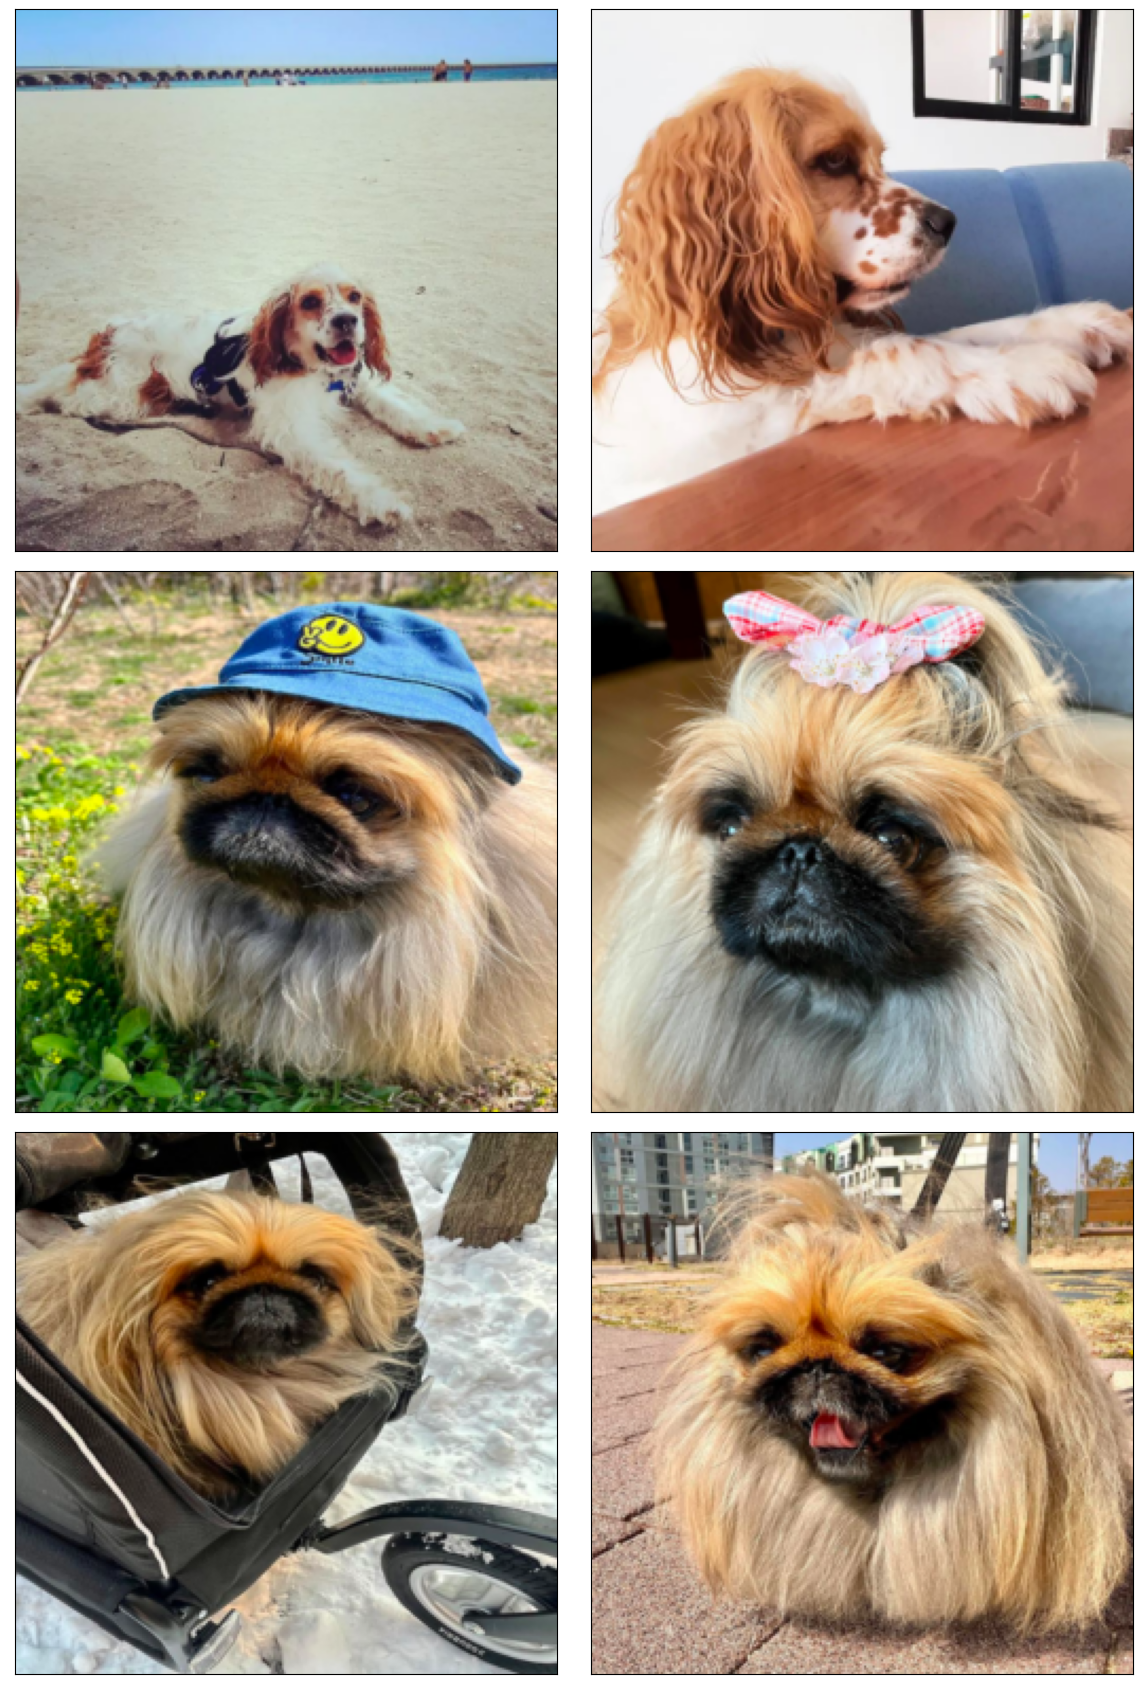

In [4]:
preview_image_data(ImagePairDataset(train_same, 1.0), transforms=Resize((256, 256)))

In [7]:
# transform = Compose([
#     Resize((512, 512)), 
#     ToTensor(), 
#     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()   

train_dataset_same = ImagePairDataset(train_same, transforms=transform, label=1)
train_dataset_diff = ImagePairDataset(train_diff, transforms=transform, label=0)

train_dataloader_same = DataLoader(train_dataset_same, batch_size=2, shuffle=True, num_workers=4)
train_dataloader_diff = DataLoader(train_dataset_diff, batch_size=2, shuffle=True, num_workers=4)

train_dataset_full = train_dataset_same + train_dataset_diff
train_dataloader_full = DataLoader(train_dataset_full, batch_size=2, shuffle=True, num_workers=4)


In [12]:

model = Detector()
model((torch.rand(2, 3, 512, 512), torch.rand(2, 3, 512, 512)))

tensor([[0.1413],
        [0.0781]], grad_fn=<AddmmBackward0>)

In [4]:
from drecg.training.loops import train, train_full

In [8]:
train(model, train_dataloader_same, train_dataloader_diff, device=torch.device('cuda'))

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 0
Epoch 0: 1.4065833573341369
Epoch 1
Epoch 1: 1.38749693775177
Epoch 2
Epoch 2: 1.3830172052383423
Epoch 3
Epoch 3: 1.36982430934906
Epoch 4
Epoch 4: 1.3639198949337006
Epoch 5
Epoch 5: 1.3584910078048706
Epoch 6
Epoch 6: 1.3574458882808684
Epoch 7
Epoch 7: 1.3536435804367066
Epoch 8
Epoch 8: 1.3389147961139678
Epoch 9
Epoch 9: 1.3444057488441468


In [8]:
train_full(model, train_dataloader_full, device=torch.device('cuda'))

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0
Epoch 0: 0.7034319620132446
Epoch 1
Epoch 1: 0.6936210943460465
Epoch 2
Epoch 2: 0.693158322930336
Epoch 3
Epoch 3: 0.6932960042953491
Epoch 4
Epoch 4: 0.6924933294057846
Epoch 5
Epoch 5: 0.692361326098442
Epoch 6
Epoch 6: 0.691613172531128
Epoch 7
Epoch 7: 0.6923115965127945
Epoch 8
Epoch 8: 0.6932706743478775
Epoch 9
Epoch 9: 0.6932452400922775


In [9]:
test_dataset_same = ImagePairDataset(test_same, transforms=transform, label=1)
test_dataset_diff = ImagePairDataset(test_diff, transforms=transform, label=0)

test_dataloader_same = DataLoader(test_dataset_same, batch_size=8, shuffle=True, num_workers=4)
test_dataloader_diff = DataLoader(test_dataset_diff, batch_size=8, shuffle=True, num_workers=4)
test_batch_same_iter = iter(test_dataloader_same)
test_batch_diff_iter = iter(test_dataloader_diff)

In [24]:
device = torch.device('cuda')
model.to(device)
test_batch_same = next(test_batch_same_iter)
test_batch_diff = next(test_batch_diff_iter)
batch_img_a = test_batch_same[0][1].to(device)
batch_img_b = test_batch_same[0][0].to(device)

batch_diff_img_a = test_batch_diff[0][1].to(device)
batch_diff_img_b = test_batch_diff[0][0].to(device)

model.eval()
with torch.no_grad():
    y_same = model((batch_img_a, batch_img_b))
    y_diff = model((batch_diff_img_a, batch_diff_img_b))

torch.round(torch.sigmoid(y_same)), torch.round(torch.sigmoid(y_diff))
# (torch.sigmoid(y_same)), (torch.sigmoid(y_diff))

(tensor([[1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

(tensor([[1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.]], device='cuda:0'))

In [31]:
i = iter(train_dataloader_full)

In [30]:
model = torch.hub.load("facebookresearch/swag", model="vit_l16_in1k")

Downloading: "https://github.com/facebookresearch/swag/zipball/main" to /home/daniel/data/.torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/SWAG/vit_l16_in1k.torch" to /home/daniel/data/.torch/hub/checkpoints/vit_l16_in1k.torch


  0%|          | 0.00/1.14G [00:00<?, ?B/s]

In [33]:
type(model)

models.vision_transformer.ViTL16

In [55]:
vit = create_vit_feat_ext()

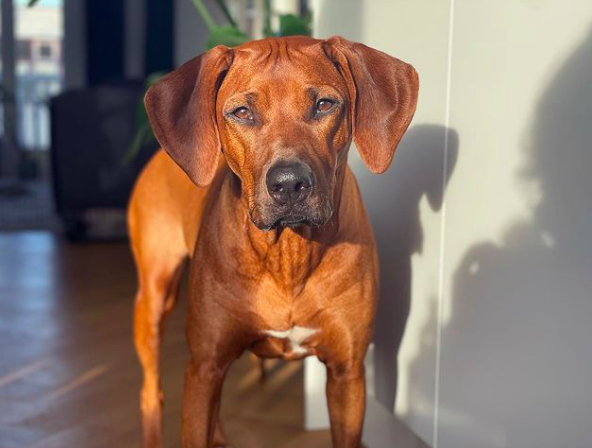

In [35]:
ds = ImagePairDataset(train_same, 1.0)
dog = ds[0][0][0]
dog

In [8]:
detector = Detector(create_vit_feat_ext)

/home/daniel/mambaforge/envs/recg/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


In [9]:
train_full(detector, train_dataloader_full, device=torch.device('cuda'))

  0%|          | 0/19990 [00:00<?, ?it/s]

Epoch 0


RuntimeError: CUDA out of memory. Tried to allocate 130.00 MiB (GPU 0; 23.68 GiB total capacity; 21.06 GiB already allocated; 105.31 MiB free; 21.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:

def try_model(model):
    device = torch.device('cuda')
    model.to(device)
    test_batch_same = next(test_batch_same_iter)
    test_batch_diff = next(test_batch_diff_iter)
    batch_img_a = test_batch_same[0][1].to(device)
    batch_img_b = test_batch_same[0][0].to(device)

    batch_diff_img_a = test_batch_diff[0][1].to(device)
    batch_diff_img_b = test_batch_diff[0][0].to(device)

    model.eval()
    with torch.no_grad():
        y_same = model((batch_img_a, batch_img_b))
        y_diff = model((batch_diff_img_a, batch_diff_img_b))

    return torch.round(torch.sigmoid(y_same)), torch.round(torch.sigmoid(y_diff))

In [26]:
try_model(detector)

(tensor([[1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.]], device='cuda:0'),
 tensor([[0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.]], device='cuda:0'))

#### Vit Model Verification
* Verify the model works with the pretrained weights for dog classification
* Prepare a Batch of Images
* Load the Pretrained Model (create function)
* Execute prediction
* Load the label descriptions
* Display the results with images and labels

In [3]:
from torchvision.transforms.functional import to_pil_image

transform = ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()   
images_to_use = train_same[20:23]
dataset = ImagePairDataset(images_to_use, transforms=transform, label=1)

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
denorm = Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1.0 / s for s in std],
)

def create_vit_feat_ext(remove_head=True):
    vit_model = vit_l_16(weights=ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1)
    if remove_head:
        vit_model.heads = nn.Identity()
    return vit_model

dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
dataloader_iter = iter(dataloader)
batch = next(dataloader_iter)

def tranformed_to_pil(transformed):
    return to_pil_image((denorm(transformed)*255).to(torch.uint8))

In [4]:
vit_extractor = create_vit_feat_ext(remove_head=True)
f_extractor = lambda: vit_extractor

model = Detector(feature_extractor=f_extractor, features_dim=1024, hidden_dim=256)

In [9]:
# model.to(torch.device('cuda'))
device = torch.device('cuda')
model((torch.randn(2, 3, 512, 512).to(device), torch.randn(2, 3, 512, 512).to(device)))

RuntimeError: CUDA out of memory. Tried to allocate 130.00 MiB (GPU 0; 23.68 GiB total capacity; 21.11 GiB already allocated; 47.19 MiB free; 21.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

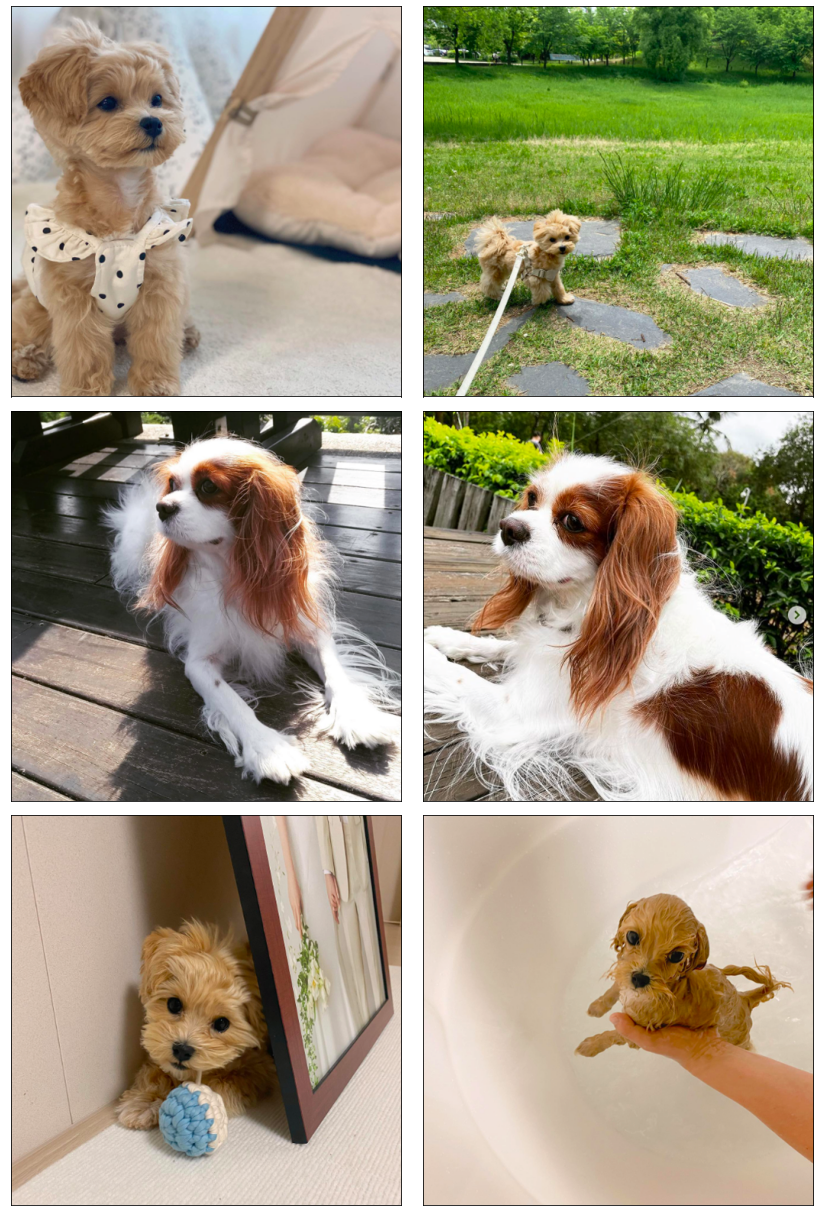

In [20]:
preview_image_data(dataset, base_idx=0, transforms=tranformed_to_pil)

In [21]:
x, y = batch
img_batch = x[0]

In [5]:
vit_model = create_vit_feat_ext(remove_head=False)
device = torch.device('cuda')
vit_model.to(device);

In [6]:
label_desc = ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.meta['categories']

In [24]:
vit_model.train()
# with torch.no_grad():
out = vit_model(img_batch.to(device))
# out2 = vit_model(img_batch.to(device))

In [23]:
del out, out2
# del vit_model
torch.cuda.empty_cache()

In [25]:
preds = torch.argmax(out, dim=1)
#convert to labels
[label_desc[pred] for pred in preds]

['toy poodle', 'Blenheim spaniel', 'toy poodle']

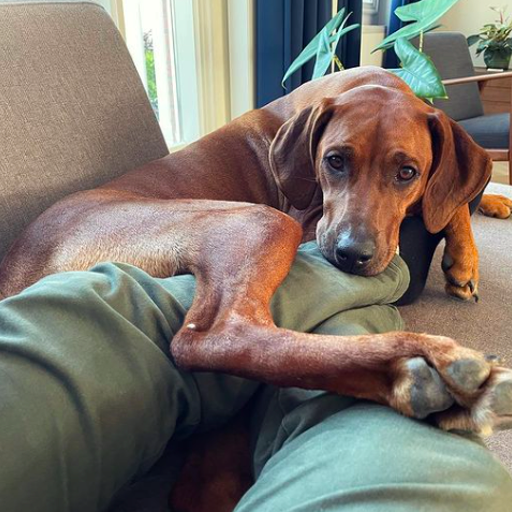

In [17]:
tranformed_to_pil(img_batch[1])

In [26]:
vit_model

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (